In [11]:
import random
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tflib as lib
import tflib.ops.linear
import matplotlib.pyplot as plt
from random import randint
from scipy.stats import wasserstein_distance

In [2]:
def loadfile(filename):
    pickle_in = open("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/" + filename + ".pickle","rb")
    return pickle.load(pickle_in)

def save2file(filename, data):
    pickle_out = open("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/" + filename + ".pickle", "wb")
    pickle.dump(data, pickle_out, protocol=pickle.HIGHEST_PROTOCOL)
    pickle_out.close()

main_str = str(437)

filename = "gan_train_" + main_str
gan_data = loadfile(filename)
display(gan_data.head())
print(gan_data.shape)

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,1,0,0,0,0,0,0,0.460752,0.690727,0.289209,...,0.459836,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0.704294,0.457027,0.217206,...,0.565490,0,1,0,0,1,0,1,0,0
2,0,0,0,0,1,0,0,0.763681,0.690727,0.289209,...,0.314966,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0.463889,0.690727,0.289209,...,0.681866,0,1,0,0,1,0,1,0,0
4,0,0,0,0,0,1,0,0.743854,0.690727,0.289209,...,0.314966,0,1,0,0,0,0,1,0,0


(260391, 160)


In [3]:
# Configuration Parameter
DEVICES = ['/cpu:0']
MODE = "wgan_gp" #wgan #wgan_gp
num_epochs = int(10);             BATCH_SIZE = int(128);   input_length_noise = int(100)
fully_connected_dim = int(80);    LAMBDA = 10 # Gradient penalty lambda hyperparameter
TTUR = False;      gen_examples = len(gan_data);

trial_str = str(randint(0, 100))
print(trial_str)

if TTUR:
    CRITIC_ITERS = 1 # disc train iterations
    D_LR = 0.0003
    G_LR = 0.0001
    BETA1_D = 0.0
    BETA1_G = 0.0
else:
    CRITIC_ITERS = 5 # disc train iterations
    D_LR = 0.0005
    G_LR = 0.0005
    BETA1_D = 0.0
    BETA1_G = 0.0

65


In [4]:
counter_read = 0;      input_length_data = -1;     add_noise_to_real_data = True;
class NetflowDataFlow():
    def __init__(self, data_file):
        def prepare_data(dp):
            global input_length_data
            global counter_read
            if input_length_data == -1: 
                input_length_data = dp.shape[1]
            lst = []
            for val in list(dp.values):
                counter_read += 1
                if counter_read % 50000 == 0:
                    print("Read lines: ", str(counter_read))
                lst.append(val)
            return lst
        print("Converting data...")
        self.data = prepare_data(gan_data)
        print("Data converted")
        random.shuffle(self.data)
        
        self.size = len(self.data)
        print(self.size)
        self.pointer = 0
    
    def sample(self, N):
        if self.pointer + N > self.size -1: 
            self.pointer = 0 
            random.shuffle(self.data)
        samples = self.data[self.pointer:self.pointer+N]
        if add_noise_to_real_data: 
            for q in range(0,N):
                noise = np.random.uniform(-0.05,0.05, input_length_data)
                samples[q] = samples[q] + noise
        self.pointer = self.pointer + N
        return samples

    def __len__(self):
        return self.size

ndf = NetflowDataFlow(gan_data)
DIM = input_length_data
print("Data_DIM, Training_rows: ", DIM, ',', counter_read)

Converting data...
Read lines:  50000
Read lines:  100000
Read lines:  150000
Read lines:  200000
Read lines:  250000
Data converted
260391
Data_DIM, Training_rows:  160 , 260391


In [5]:
def GeneratorAndDiscriminator():
    return FCGenerator, FCDiscriminator

def LeakyReLU(x, alpha=0.2):
    return tf.maximum(alpha*x, x)

def ReLULayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(name+'.Linear', n_in, n_out, inputs, initialization='he')
    return tf.nn.relu(output)

def LeakyReLULayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(name+'.Linear', n_in, n_out, inputs, initialization='he')
    return LeakyReLU(output)

def FCGenerator(n_samples, noise=None, FC_DIM=fully_connected_dim):
    if noise is None:
        noise = tf.random_normal([n_samples, input_length_noise])

    output = ReLULayer('Generator.1', input_length_noise, FC_DIM, noise)
    output = ReLULayer('Generator.2', FC_DIM, FC_DIM, output)
    output = ReLULayer('Generator.3', FC_DIM, FC_DIM, output)
    output = ReLULayer('Generator.4', FC_DIM, FC_DIM, output)
    output = ReLULayer('Generator.Out', FC_DIM, input_length_data, output)
    #output = tf.tanh(output)
    return output

def FCDiscriminator(inputs, FC_DIM=fully_connected_dim, n_layers=3):
    output = LeakyReLULayer('Discriminator.Input', input_length_data, FC_DIM, inputs)
    for i in range(n_layers):
        output = LeakyReLULayer('Discriminator.{}'.format(i), FC_DIM, FC_DIM, output)
    output = lib.ops.linear.Linear('Discriminator.Out', FC_DIM, 1, output)
    return tf.reshape(output, [-1])

Generator, Discriminator = GeneratorAndDiscriminator()

In [6]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:

    all_real_data_conv = tf.placeholder(tf.float32, shape=[BATCH_SIZE, input_length_data])
    
    if tf.__version__.startswith('1.'):
        split_real_data_conv = tf.split(all_real_data_conv, len(DEVICES))
    else:
        split_real_data_conv = tf.split(0, len(DEVICES), all_real_data_conv)
    gen_costs, disc_costs = [],[]

    for device_index, (device, real_data_conv) in enumerate(zip(DEVICES, split_real_data_conv)):
        with tf.device(device):
            
            real_data = real_data_conv
            fake_data = Generator(BATCH_SIZE//len(DEVICES))
 
            disc_fake = Discriminator(fake_data)
            disc_real = Discriminator(real_data)
            
            if MODE == 'wgan':
                gen_cost = -tf.reduce_mean(disc_fake)
                disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)

            elif MODE == 'wgan_gp':
                gen_cost = -tf.reduce_mean(disc_fake)
                disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)

                alpha = tf.random_uniform(shape=[BATCH_SIZE//len(DEVICES),1], minval=0., maxval=1.)
                differences = fake_data - real_data
                interpolates = real_data + (alpha*differences)
                gradients = tf.gradients(Discriminator(interpolates), interpolates)[0]
                slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
                gradient_penalty = tf.reduce_mean((slopes-1.)**2)
                disc_cost += LAMBDA*gradient_penalty
            else:
                raise Exception()
            
            gen_costs.append(gen_cost)
            disc_costs.append(disc_cost)

    gen_cost = tf.add_n(gen_costs) / len(DEVICES)
    disc_cost = tf.add_n(disc_costs) / len(DEVICES)

    if MODE == 'wgan':
        gen_train_op = tf.train.RMSPropOptimizer(learning_rate=G_LR).minimize(gen_cost,
                                             var_list=lib.params_with_name('Generator'), colocate_gradients_with_ops=True)
        disc_train_op = tf.train.RMSPropOptimizer(learning_rate=D_LR).minimize(disc_cost,
                                             var_list=lib.params_with_name('Discriminator.'), colocate_gradients_with_ops=True)
        clip_ops = []
        for var in lib.params_with_name('Discriminator'):
            clip_bounds = [-.01, .01]
            clip_ops.append(tf.assign(var, tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])))
        clip_disc_weights = tf.group(*clip_ops)

    elif MODE == 'wgan_gp':
        gen_train_op = tf.train.AdamOptimizer(learning_rate=G_LR, beta1=BETA1_G, beta2=0.9).minimize(gen_cost,
                                          var_list=lib.params_with_name('Generator'), colocate_gradients_with_ops=True)
        disc_train_op = tf.train.AdamOptimizer(learning_rate=D_LR, beta1=BETA1_D, beta2=0.9).minimize(disc_cost,
                                           var_list=lib.params_with_name('Discriminator.'), colocate_gradients_with_ops=True)
        
    # generating samples
    fixed_noise = tf.constant(np.random.normal(size=(BATCH_SIZE, input_length_noise)).astype('float32'))
    all_fixed_noise_samples = []
    for device_index, device in enumerate(DEVICES):
        n_samples = BATCH_SIZE // len(DEVICES)
        all_fixed_noise_samples.append(Generator(n_samples,
                                                 noise=fixed_noise[device_index*n_samples:(device_index+1)*n_samples]))
    if tf.__version__.startswith('1.'):
        all_fixed_noise_samples = tf.concat(all_fixed_noise_samples, axis=0)
    else:
        all_fixed_noise_samples = tf.concat(0, all_fixed_noise_samples)

    session.run(tf.global_variables_initializer())

    # generating samples
    samples_examples = Generator(gen_examples)
    def generate_final_flows(out_text):
        samples = session.run(samples_examples)
        
        was = 0
        for i in range(samples.shape[1]):
            was += wasserstein_distance(samples[:, i], gan_data.values[:, i])         
        was /= samples.shape[1]
        
        filename = out_text + '_' + main_str
        save2file(filename, samples)
        return was

    ITERS = int((num_epochs * counter_read) / BATCH_SIZE )
    epoch = 0; train_loss = []; w_dis = []; epoch_wdis = 0;
    _gen_cost = 0; old_epoch = 0;
    
    for iteration in range(ITERS):
        epoch = int((iteration * BATCH_SIZE) / counter_read)
        if epoch > old_epoch:
            epoch_wdis = generate_final_flows(MODE + "_epoch" + str(epoch))
            w_dis.append(epoch_wdis)
            
        old_epoch = epoch
        
        # Train generator
        if iteration > 0:
            _gen_cost, _ = session.run([gen_cost, gen_train_op])
        
        # Train discriminator
        disc_iters = CRITIC_ITERS
        for i in range(disc_iters):
            _data = ndf.sample(BATCH_SIZE)
            _disc_cost, _ = session.run([disc_cost, disc_train_op], feed_dict={all_real_data_conv: _data})
            
            if MODE == "wgan":
                _ = session.run([clip_disc_weights])
        
        if iteration % int((counter_read) / BATCH_SIZE ) == 0:
            print("Step ", iteration, " From ", ITERS, "(","Epoch", epoch,"): Disc_cost:", _disc_cost, " Gen_cost:", _gen_cost)
            print("Wasserstein dist:", epoch_wdis, '\n')
            
        train_loss.append([_gen_cost, _disc_cost])
    
    # Store final outputs
    finalwdis = generate_final_flows(MODE + "_final")
    print("Final Wasserstein dist:", finalwdis)
    w_dis.append(epoch_wdis)
    
print('training finished...')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Step  0  From  20343 ( Epoch 0 ): Disc_cost: -0.27167922  Gen_cost: 0
Wasserstein dist: 0 

Step  2034  From  20343 ( Epoch 0 ): Disc_cost: -0.7376862  Gen_cost: 1.634345
Wasserstein dist: 0 

Step  4068  From  20343 ( Epoch 1 ): Disc_cost: -0.51762086  Gen_cost: 1.6361891
Wasserstein dist: 0.045189504545005685 

Step  6102  From  20343 ( Epoch 2 ): Disc_cost: -0.46007854  Gen_cost: 1.5831397
Wasserstein dist: 0.03583141134054382 

Step  8136  From  20343 ( Epoch 3 ): Disc_cost: -0.40747404  Gen_cost: 1.5769234
Wasserstein dist: 0.03223700894354691 

Step  10170  From  20343 ( Epoch 4 ): Disc_cost: -0.33558002  Gen_cost: 1.2895074
Wasserstein dist: 0.031223845462770107 

Step  12204  From  20343 ( Epoch 5 ): Disc_cost: -0.29197896  Gen_cost: 1.1616955
Wasserstein dist: 0.02812383479276742 

Step  14238  From  20343 ( Epoch 6 ): Disc_cost: -0.3059942  Gen_cost: 1.0722555
Wasserstein dist: 0.026

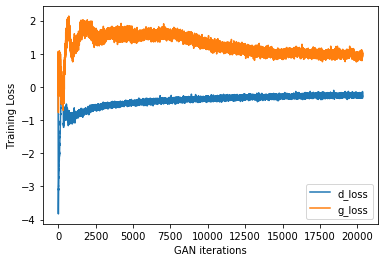

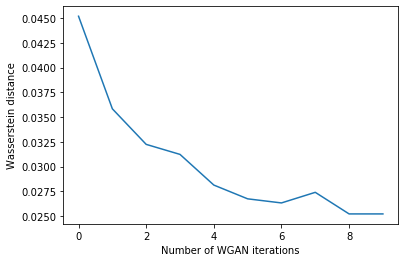

In [7]:
filename = MODE + '_train_loss_' + main_str
save2file(filename, train_loss)

filename = MODE + '_wass_dis'
save2file(filename, w_dis)

tt = np.arange(ITERS)
plt.plot(tt, np.array(train_loss)[:, 1], label='d_loss')
plt.plot(tt, np.array(train_loss)[:, 0], label='g_loss')
plt.legend()
plt.xlabel('GAN iterations')
plt.ylabel('Training Loss')
plt.savefig('C:/Users/Akarsh/Downloads/DP_scripts/store_emb/' + MODE + '_gan_loss_' + main_str +'.png')
plt.show()

X = list(range(0, len(w_dis)))
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(X, w_dis)
ax.set_xlabel("Number of WGAN iterations")
ax.set_ylabel("Wasserstein distance")
fig.savefig("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/" +  MODE + "_wasserstein_plot.png")
plt.show()

In [8]:
save = True
if save:
    df = pd.DataFrame.from_records([{'operation': 'gan_train', 'main_str': main_str, 'trial_str': trial_str, 'MODE': MODE, 
                                     'fully_connected_dim': fully_connected_dim, 'ITERS': ITERS,
                                     'batch_size': BATCH_SIZE, 'gradient_pen': LAMBDA, 'clip_weights': 0.01,
                                     'TTUR': 'yes_keep_default', 'gen_examples_len': gen_examples, 
                                     'add_noise_to_real_data': add_noise_to_real_data}])

    df.to_csv("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/store_params.csv", mode='a', index=False)
    print('data and hyperparams saved...')

data and hyperparams saved...
